# **INGESTING PDFs (Probability Density Functions)** #

#### Objectives: ####
+ Getting familiar on how [STORM](../README.md) reads input data
+ Recipes for plotting statistics (via [Seaborn](https://seaborn.pydata.org/) and [Matplotlib](https://matplotlib.org/))

---

The cornerstone of STORM is its stochastic framework which is built upon probability density functions (PDFs).
A PDF is a mathematical conduit that allows the modeling of (measurable) random variables.
STORM simulates storm throughout the following random (natural) variables:
+ ```TOTALP``` - total seasonal rainfall
+ ```RADIUS``` - maximum storm radius
+ ```BETPAR``` - decay rate (of maximum rainfall from the storm's centre towards its maximum radius)
+ ```MAXINT``` - (maximum) rainfall intensity
+ ```AVGDUR``` - (average) storm duration
+ ```COPULA``` - copula's correlation parameter
+ ```WINDIR``` - storm's core direction
+ ```WSPEED``` - storm's advection velocity
+ ```DOYEAR``` - storm's starting date
+ ```DATIME``` - storm's starting time

The aforementioned variables are modeled via several (families of) PDFs.
Below there's an excerpt of the [PDFs-file](../model_input/ProbabilityDensityFunctions_TWO.csv) that contains the parameters defining such PDFs.\
<span style="color:HotPink">*Caveat: The parameters here presented do not correspond to the actual hydrometeorology of the HAD (Horn-of-Africa Drylands) region.
For the present exercise they're just numbers that enables running the code/script(s).*</span>

```
TOTALP_PDF1+gumbel_l,5.511633973257439,0.2262071569584096
RADIUS_PDF1+johnsonsb,1.5187255885489825,1.269645240869123,-0.27894731916038973,20.797740488039622
BETPAR_PDF1+exponnorm,8.287219232100437,0.017846553384616465,0.010045344544579145
MAXINT_PDF1+expon,0.10575951772499326,6.995586774590339
AVGDUR_PDF1+geninvgauss,-0.0898831096228784,0.7703680797104097,2.843259631396887,82.07861011421329
COPULA_RHO1+,-0.31622002749035444
WINDIR_PDF1+vonmises,2.836341,0.00001
WSPEED_PDF1+norm,7.55,1.9
DATIME_VMF1+m1,0.2468419551426534,0.6893273101866058,6.418276632248997
DATIME_VMF1+m2,0.3315907829508499,1.703495074238532,3.000253688430609
DATIME_VMF1+m3,0.4215672619064808,2.57569021558914,0.4649344363713587
DOYEAR_VMF1+m1,0.05446271224933757,1.907409236571684,105.3227046311876
DOYEAR_VMF1+m2,0.08954689198507723,0.2286006656480273,51.97011694272198
DOYEAR_VMF1+m3,0.07054990890263783,1.551363989955984,87.19112504916305
DOYEAR_VMF1+m4,0.0873236680883794,1.17264771241493,52.91419173073581
DOYEAR_VMF1+m5,0.6981168187745506,0.5586619737368196,6.828147043994408
```

In the previous segment of, for instance, the first line defines the modeling of total seasonal rainfall ```TOTALP```, for Season 1 (in the logarithmic-space), as a [left-skewed Gumbel](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_l.html#scipy.stats.gumbel_l) distribution with $\mu \approx 5.51$ and $\sigma^2 \approx 0.266$.\
<span style="color:RoyalBlue">*Ideally, the PDF-file is produced by a pre-pocessing script (still in development --as of this date--), and/or can be directly modified/overwritten with your own parameterization (if you now what you're doing).*</span>

---

The retrieveal, setting, and sampling of PDFs is done by STORM through the functions: READ_PDF_PAR, RETRIEVE_PDF, CHECK_PDF, RANDOM_SAMPLING, TRUNCATED_SAMPLING, SEASONAL_RAIN, ENHANCE_SR, COPULA_SAMPLING, TOD_CIRCULAR, and TOD_DISCRETE of the [rainfall.py](../rainfall.py) module.

---

## <u>HANDLING JUST ONE PDF AT A TIME</u> ##

The exercise below is about constructing and visualizing just one PDF (i.e., ```RADIUS``` - maximum storm radius).\
<span style="color:MediumSeaGreen">*You are encouraged to find what the (first half of the) other PDFs look like.*</span>

In [62]:
# loading libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

Let's read the [PDFs-file](../model_input/ProbabilityDensityFunctions_TWO.csv).
It comes with two seasons but we'll use just one.

In [63]:
# https://stackoverflow.com/a/58227453/5885810  -> import tricky CSV
file_pdfs = "../model_input/ProbabilityDensityFunctions_TWO.csv"
PDFS = pd.read_fwf(file_pdfs, header=None)
PDFS = PDFS.__getitem__(0).str.split(",", expand=True).set_index(0).astype("f8")

# how does it look like?
print(PDFS)

                                   1          2           3          4
0                                                                     
TOTALP_PDF1+gumbel_l        5.511634   0.226207         NaN        NaN
TOTALP_PDF2+norm            5.362910   0.316761         NaN        NaN
RADIUS_PDF1+johnsonsb       1.518726   1.269645   -0.278947  20.797740
RADIUS_PDF2+gamma           4.399626  -0.475113    1.399112        NaN
BETPAR_PDF1+exponnorm       8.287219   0.017847    0.010045        NaN
BETPAR_PDF2+burr            2.351236   0.850598   -0.001137   0.083777
MAXINT_PDF1+expon           0.105760   6.995587         NaN        NaN
AVGDUR_PDF1+geninvgauss    -0.089883   0.770368    2.843260  82.078610
MAXINT_PDF1+Z1+expon        0.109404   5.760539         NaN        NaN
MAXINT_PDF1+Z2+expon        0.105760   7.113553         NaN        NaN
MAXINT_PDF1+Z3+expon        0.305323   7.352659         NaN        NaN
AVGDUR_PDF1+Z1+geninvgauss -0.105857   0.609322    5.046340  74.205047
AVGDUR

STORM re-shapes the above matrix, and coverts it (according to a given PDF-selection) into dictionaries of PDFs.
Something like this:

In [64]:
# here the RADIUS-PDFs for the two season are stored in one list
RADIUS = [
    {"": stats.johnsonsb(1.5187, 1.2696, -0.2789, 20.7977)},
    {"": stats.gamma(4.3996, -0.475, 1.399)},
]

# how does it look like?
list(map(print, RADIUS))

{'': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C11FEC05E0>}
{'': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002C11FCA07C0>}


[None, None]

Now we "trace" individually each PDF (just to see the variations in/on the PDFs.
The selected/established PDFs are [johnsonsb](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.johnsonsb.html#scipy-stats-johnsonsb) (for season 1) and [gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy-stats-gamma) (for season 2 --if we're tracking seasons--).
[Scipy](https://docs.scipy.org/doc/scipy/index.html) is the library in charge of handling PDFs.

In [65]:
johns = RADIUS[0][""]
gamma = RADIUS[1][""]

# seed... to have some consistency among runs
np.random.seed(seed=42)
# here is where the "random" sampling is done
h_johns = pd.DataFrame({"distribution": "johnsonsb", "samples": johns.rvs(size=400)})
h_gamma = pd.DataFrame({"distribution": "gamma", "samples": gamma.rvs(size=300)})

We then group the previous outputs into a [Pandas](https://pandas.pydata.org/docs/) dataframe, so we can easily plot them together later.

In [66]:
data = pd.concat([h_johns, h_gamma], ignore_index=True)

# how does it look like?
print(data)

    distribution    samples
0      johnsonsb   3.678668
1      johnsonsb  10.664618
2      johnsonsb   6.581684
3      johnsonsb   5.316964
4      johnsonsb   2.216708
..           ...        ...
695        gamma   8.466893
696        gamma   4.631129
697        gamma   2.597868
698        gamma   6.362148
699        gamma   5.696321

[700 rows x 2 columns]


### Visualization ###

First, let's define/call some nice Font Types.

In [67]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.family"] = "Trebuchet MS", "Impact", "Candara", "Papyrus"

Then, let's define some basic variables to be shared among the data/plot.

In [68]:
_size = 200  # -> number of bins to split the X.axis
x_min = 0
x_max = 20
s_tep = abs(x_max - x_min) / _size  # -> resolution of the X.axis
x_axis = np.linspace(x_min, x_max, num=_size + 1, endpoint=True)

Now, let's "compute" the PDFs for the values in ```x_axis```.

In [69]:
d_johns = johns.pdf(x_axis)
d_gamma = gamma.pdf(x_axis)

# what are 'd_johns' and 'd_gamma'?
print(d_johns[:12])
print(d_gamma[:12])

[0.00078869 0.00255882 0.0056964  0.01022536 0.01600589 0.02281604
 0.03040706 0.03853594 0.04698228 0.05555549 0.06409643 0.072476  ]
[0.0012772  0.00227664 0.00365583 0.00544392 0.00765683 0.01029853
 0.01336251 0.0168333  0.02068797 0.02489752 0.02942824 0.03424292]


Finally, let's do the plotting... 
<span style="color:RoyalBlue">*(Color names taken from [Colors-XKCD](https://www.w3schools.com/colors/colors_xkcd.asp))*</span>\
<a id='binw-ref'></a>

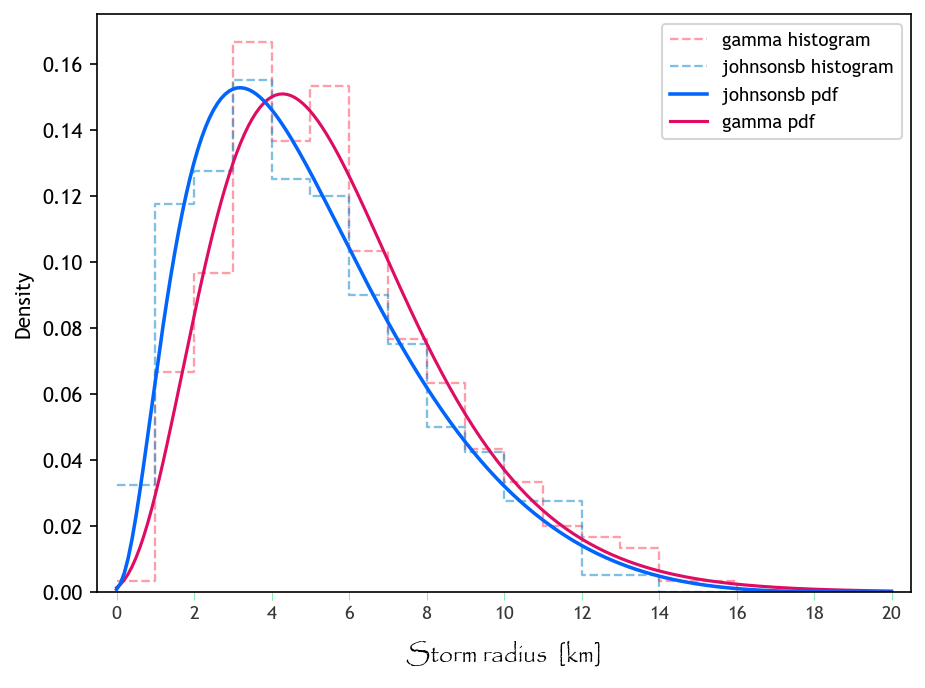

In [80]:
# some more parameters...
binw = 1
xbin = np.linspace(x_min, x_max, num=int(abs(x_max - x_min) / binw + 1), endpoint=True)
xlab = np.linspace(x_min, x_max, num=10 + 1, endpoint=True)

# the plot starts here
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)

# seaborn histogram
# https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(
    data=data,
    x="samples",
    hue="distribution",
    stat="density",
    ax=ax,
    multiple="layer",
    alpha=0.53,
    bins=xbin,  # binwidth=binw
    element="step",
    fill=False,
    lw=1.1,
    ls="dashed",
    palette={"johnsonsb": "xkcd:water blue", "gamma": "xkcd:watermelon"},
    common_norm=False,
    zorder=0,
    # edgecolor='xkcd:washed out green',
)

# PDF-curves
# use this if stat=='density'
ax.plot(x_axis, d_johns, color="xkcd:bright blue", lw=1.7, ls="solid", zorder=2)
ax.plot(x_axis, d_gamma, color="xkcd:cerise", lw=1.5, ls="solid", zorder=1)

# # use this if stat=='probability'
# ax.plot(
#     x_axis,
#     d_johns / d_johns.sum() * binw / s_tep,
#     color="xkcd:bright blue",
#     lw=1.7,
#     ls="solid",
#     zorder=2,
# )
# ax.plot(
#     x_axis,
#     d_gamma / d_gamma.sum() * binw / s_tep,
#     color="xkcd:cerise",
#     lw=1.5,
#     ls="solid",
#     zorder=1,
# )

# custom legend
ax.legend(
    labels=["gamma histogram", "johnsonsb histogram", "johnsonsb pdf", "gamma pdf"],
    loc="upper right",
    fontsize=9,
)

# tweaking axes-stuff
ax.set_xticks(xlab)
# turn xlabs into integer-strings
ax.set_xticklabels(
    labels=[str(int(x)) for x in xlab], fontdict={"size": 9, "color": "xkcd:charcoal"}
)
ax.tick_params(
    axis="x",
    which="major",
    direction="out",
    pad=+2,
    color="xkcd:weird green",
    length=4,
    width=0.3,
)
ax.set_xlim([x_min - 0.5, x_max + 0.5])
plt.xlabel(
    r"Storm radius  [km]",
    fontsize=12,
    color="xkcd:black",
    labelpad=9,
    fontname="Papyrus",
)

# # activate this block for more fun-control
# ax.set_yticks(np.linspace(0, 0.16, 5), minor=False)
# ax.tick_params(
#     axis="y",
#     which="major",
#     direction="in",
#     pad=1.5,
#     color="xkcd:charcoal",
#     labelcolor="xkcd:charcoal",
#     labelsize=11,
#     length=3,
# )
# plt.ticklabel_format(axis="y", style="sci", scilimits=(1, -2))
# # doing minor ticks
# ax.set_yticks(np.linspace(0, 0.17, 18), labels=None, minor=True)
# ax.tick_params(
#     axis="y",
#     which="minor",
#     direction="in",
#     color="xkcd:charcoal",
#     length=1.5,
#     width=0.5,
# )
# ax.set_ylim([0, 0.17])
# plt.ylabel("density  [-]", fontsize=12, color="xkcd:black", labelpad=13)

# plt.title("some unnecessary title")

plt.show()

# # use these for exporting and cleaning [don't forget to comment out "plt.show()"!!]
# plt.savefig(
#     "one_.pdf", bbox_inches="tight", pad_inches=0.02, facecolor=fig.get_facecolor()
# )
# plt.close()
# plt.clf()

<span style="color:MediumSeaGreen">I'd would ask then... what would the above graph look like if [**binw**](#binw-ref) is different from **1**??</span>